### Libraries Importing

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt


In [14]:
dataframe = pd.read_csv('iris.csv')
print(dataframe.head())
# Check if there are any NaN values in the DataFrame
if dataframe.isna().any().any():
    print("There are NaN values in the DataFrame.")
else:
    print("There are no NaN values in the DataFrame.")

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
There are no NaN values in the DataFrame.


In [15]:
# features
features = dataframe.drop('species', axis=1).values
# target
target = dataframe['species'].values

# Normalizing the data
scaler = Normalizer()
features = scaler.fit_transform(features)

# mapping the target to integers using mappping function
mapping = {k: v for v, k in enumerate(np.unique(target))}
target = np.array([mapping[i] for i in target])

# splitting the data into training and testing
X_train, X_test_val, y_train, y_test_val = train_test_split(features, target, test_size=0.2)
X_test , X_val , y_test , y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)


In [16]:
class myModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)
    
    # training the model with given batch size
    def train(self, X_train, y_train, X_val, y_val, batch_size, epochs):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        training_losses = []
        validation_losses = []
        for epoch in range(epochs):
            self.model.train()
            for i in range(0, len(X_train), batch_size):
                inputs = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                labels = torch.tensor(y_train[i:i+batch_size], dtype=torch.long)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            training_losses.append(loss.item())
            
            # Validation
            self.model.eval()
            with torch.no_grad():
                val_inputs = torch.tensor(X_val, dtype=torch.float32)
                val_labels = torch.tensor(y_val, dtype=torch.long)
                val_outputs = self.model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                validation_losses.append(val_loss.item())
                if epoch % 10 == 0:
                    print(f'Epoch: {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
        
        plt.plot(training_losses, label='Training Loss')
        plt.plot(validation_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, X):
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = self.model(inputs)
        return torch.argmax(outputs, dim=1).numpy()
    

Epoch: 0, Training Loss: 1.1002618074417114, Validation Loss: 1.0993040800094604
Epoch: 10, Training Loss: 1.0687428712844849, Validation Loss: 1.0616296529769897
Epoch: 20, Training Loss: 0.9871989488601685, Validation Loss: 0.9703304171562195
Epoch: 30, Training Loss: 0.8919409513473511, Validation Loss: 0.8704745769500732
Epoch: 40, Training Loss: 0.837237536907196, Validation Loss: 0.812187135219574
Epoch: 50, Training Loss: 0.7991798520088196, Validation Loss: 0.7725008130073547
Epoch: 60, Training Loss: 0.7645841240882874, Validation Loss: 0.7376219630241394
Epoch: 70, Training Loss: 0.7313550710678101, Validation Loss: 0.7050281763076782
Epoch: 80, Training Loss: 0.7025017738342285, Validation Loss: 0.67730313539505
Epoch: 90, Training Loss: 0.6793869733810425, Validation Loss: 0.6555706262588501


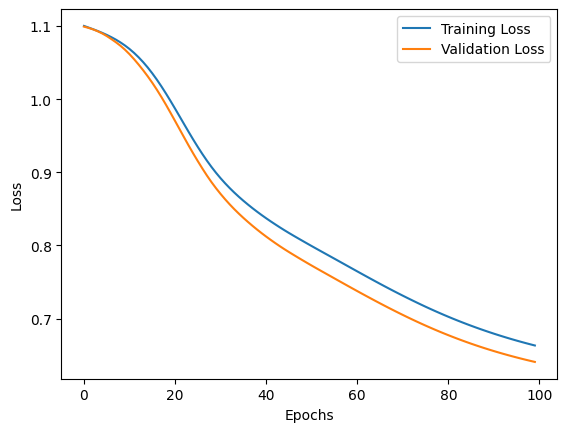

In [17]:
# creating the model
model = myModel(4, 10, 3)
model.train(X_train, y_train, X_val, y_val, 64, 100)


In [18]:
# Testing the model
y_pred = model.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')


Test Accuracy: 1.0


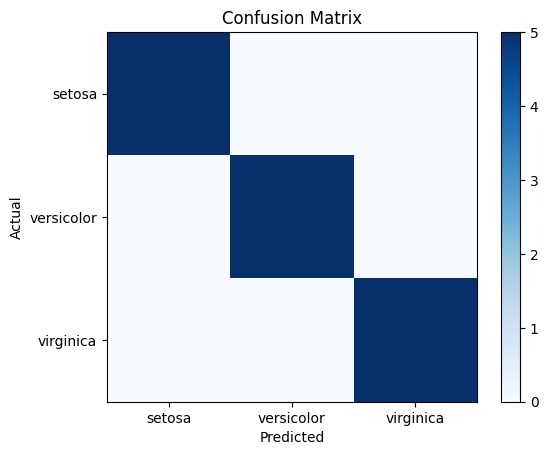

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         5
  versicolor       1.00      1.00      1.00         5
   virginica       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [19]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(3), ['setosa', 'versicolor', 'virginica'])
plt.yticks(np.arange(3), ['setosa', 'versicolor', 'virginica'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# print classification report
print(classification_report(y_test, y_pred, target_names=['setosa', 'versicolor', 'virginica']))

ROC AUC: 1.0


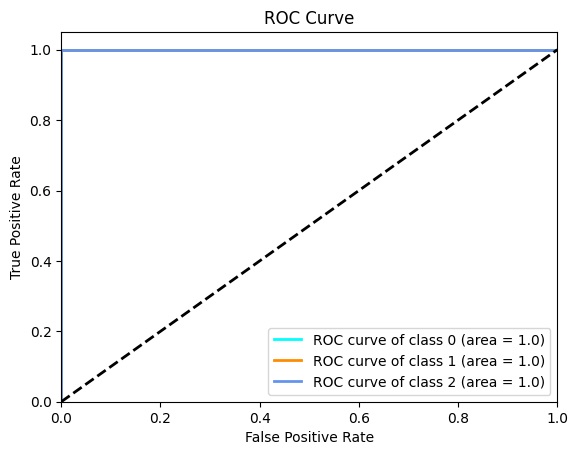

In [20]:
# ROC AUC
y_pred = model.predict(X_test)
y_test_onehot = np.eye(3)[y_test]
y_pred_onehot = np.eye(3)[y_pred]
roc_auc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
